In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from email.parser import Parser
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Download necessary components
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
sia = SentimentIntensityAnalyzer()
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rmhs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\rmhs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rmhs/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
#read in data and understand data shape
df = pd.read_csv('../data/emails_NLP.csv')
#print(df.head())
print(df.info())
#print(df.iloc[30010:30015])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB
None


In [3]:
df_feature = df.copy()

df_feature['employee'] = df_feature['file'].apply(lambda x: x.split('/')[0])

employee
kaminski-v    28465
dasovich-j    28234
kean-s        25351
mann-k        23381
jones-t       19950
              ...  
swerzbin-m      355
sanchez-m       256
south-s         248
slinger-r       132
phanis-s         35
Name: count, Length: 150, dtype: int64


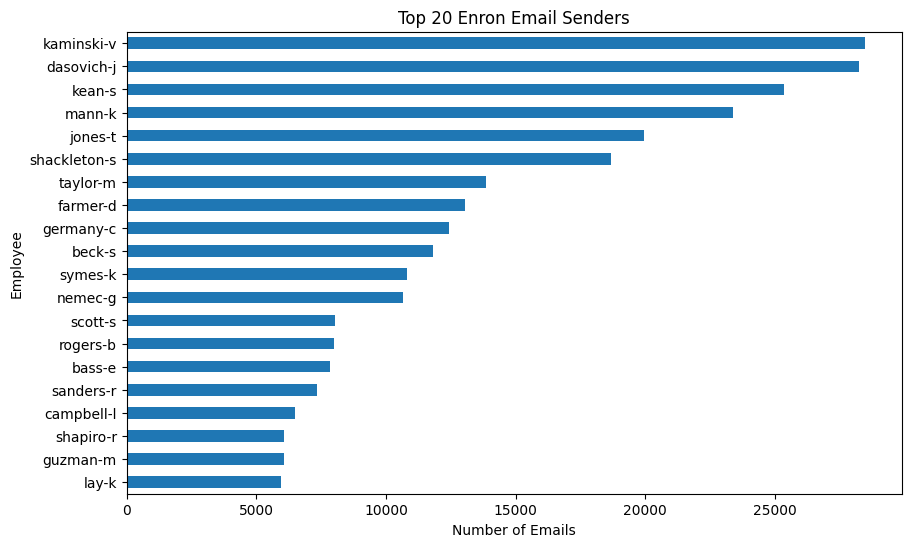

In [4]:
# EDA - Employees by email count
employee_counts = df_feature['employee'].value_counts()
print(employee_counts)
employee_counts.describe()

employee_counts.head(20).plot(kind='barh', figsize=(10, 6))
plt.xlabel("Number of Emails")
plt.ylabel("Employee")
plt.title("Top 20 Enron Email Senders")
plt.gca().invert_yaxis()
plt.show()

In [5]:
# Parse emails and extract headers
emails = list(map(Parser().parsestr, df_feature['message']))
headers_to_extract = [
    "Message-ID", "Date", "From", "To", "Subject", "Mime-Version",
    "Content-Type", "Content-Transfer-Encoding", "X-From", "X-To",
    "X-cc", "X-bcc", "X-Folder", "X-Origin", "X-FileName"
]
for key in headers_to_extract:
    df_feature[key] = [msg.get(key) for msg in emails]

def get_email_body(msg):
    if msg.is_multipart():
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload(decode=True).decode(errors='ignore')
    else:
        return msg.get_payload(decode=True).decode(errors='ignore')

df_feature['body'] = [get_email_body(msg) for msg in emails]

df_feature.info()
#print(df_feature.iloc[10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   file                       517401 non-null  object
 1   message                    517401 non-null  object
 2   employee                   517401 non-null  object
 3   Message-ID                 517401 non-null  object
 4   Date                       517401 non-null  object
 5   From                       517401 non-null  object
 6   To                         495554 non-null  object
 7   Subject                    517401 non-null  object
 8   Mime-Version               517372 non-null  object
 9   Content-Type               517372 non-null  object
 10  Content-Transfer-Encoding  517372 non-null  object
 11  X-From                     517372 non-null  object
 12  X-To                       517372 non-null  object
 13  X-cc                       517372 non-null  

Earliest date: Fri, 1 Aug 1997 01:00:00 -0700 (PDT)
Latest date: Wed, 9 Oct 2002 14:20:21 -0700 (PDT)
Filtered dataset size: (308666, 19)


C:\Users\rmhs\AppData\Local\Temp\ipykernel_12684\1459618413.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year_month'] = df_filtered['Date'].str.extract(r'(\w{3} \d{4})')
C:\Users\rmhs\AppData\Local\Temp\ipykernel_12684\1459618413.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year_month_dt'] = pd.to_datetime(df_filtered['year_month'], format='%b %Y', errors='coerce')


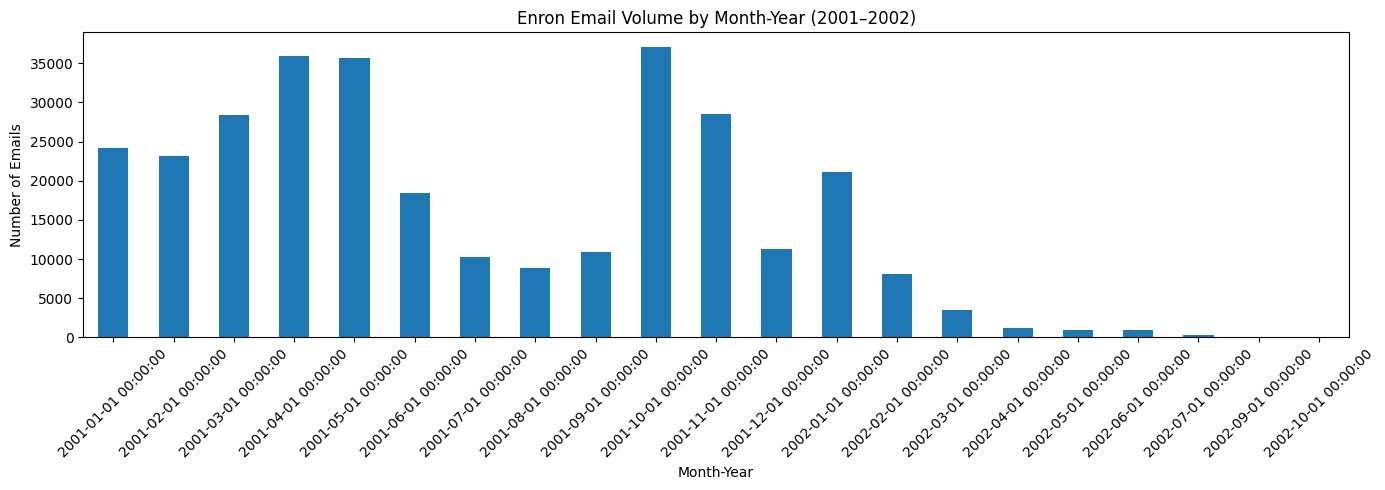

In [6]:
# Find out Earliest and Latest date in dataset
min_date = df_feature['Date'].min()
max_date = df_feature['Date'].max()
print("Earliest date:", min_date)
print("Latest date:", max_date)

#Filter time to relevant period:
df_filtered = df_feature[df_feature['Date'].str.contains(' 2001| 2002', na=False)]
print("Filtered dataset size:", df_filtered.shape)

df_filtered['year_month'] = df_filtered['Date'].str.extract(r'(\w{3} \d{4})')
df_filtered['year_month_dt'] = pd.to_datetime(df_filtered['year_month'], format='%b %Y', errors='coerce')
df_filtered = df_filtered[~df_filtered['year_month_dt'].isin([
    pd.Timestamp('2002-11-01'), pd.Timestamp('2002-12-01')
])]

# Group and count emails by year-month
volume_by_month = df_filtered.groupby('year_month_dt').size()

# Plot the volume of emails
volume_by_month.plot(kind='bar', figsize=(14, 5))
plt.title("Enron Email Volume by Month-Year (2001–2002)")
plt.xlabel("Month-Year")
plt.ylabel("Number of Emails")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Remove SPAM and PERSONAL messages
# Convert body to lowercase for filtering
df_filtered['body_lower'] = df_filtered['body'].str.lower()

# Remove spam and personal content
spam_keywords = ['pizza', 'subscribe', 'promotion', 'offer', 'discount', 'lottery', 'click here', 'buy now', 'try now']
personal_keywords = ['love', 'miss you', 'birthday', 'family', 'parents','friends' , 'annual leave', 'holiday', 'vacation', 'sick', 'dinner', 'mom', 'dad', 'wedding']

df_filteredspam = df_filtered[~df_filtered['body_lower'].str.contains('|'.join(spam_keywords), na=False)]
df_filteredpersonal = df_filteredspam[~df_filteredspam['body_lower'].str.contains('|'.join(personal_keywords), na=False)]
df_cleaned = df_filteredpersonal.dropna(subset=['From', 'Date', 'body'])

print("Remaining emails after cleaning:", df_cleaned.shape[0])

Remaining emails after cleaning: 236382


In [8]:
# Clean Text in message body for sentiment analysis
def clean_for_sentiment(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'[-=_]{2,}', ' ', text)
    text = re.sub(r'[^\w\s.,!?]', '', text)
    return text.strip()

df_cleaned['body_clean'] = df_cleaned['body'].apply(clean_for_sentiment)
df_cleaned = df_cleaned[df_cleaned['body_clean'].str.len() > 10]

sentiment_label
positive    183621
negative     25827
neutral      25773
Name: count, dtype: int64


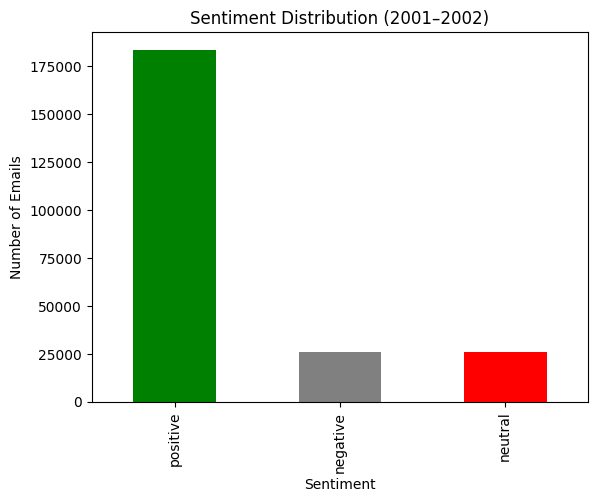

In [9]:
# Sentiment analysis using VADER

df_cleaned['sentiment_scores'] = df_cleaned['body_clean'].apply(lambda x: sia.polarity_scores(x))
df_cleaned['compound'] = df_cleaned['sentiment_scores'].apply(lambda x: x['compound'])

def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df_cleaned['sentiment_label'] = df_cleaned['compound'].apply(classify_sentiment)

# Plot Sentiment Distrubution
sentiment_distribution = df_cleaned['sentiment_label'].value_counts()
print(sentiment_distribution)

df_cleaned['sentiment_label'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Sentiment Distribution (2001–2002)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Emails")
plt.show()

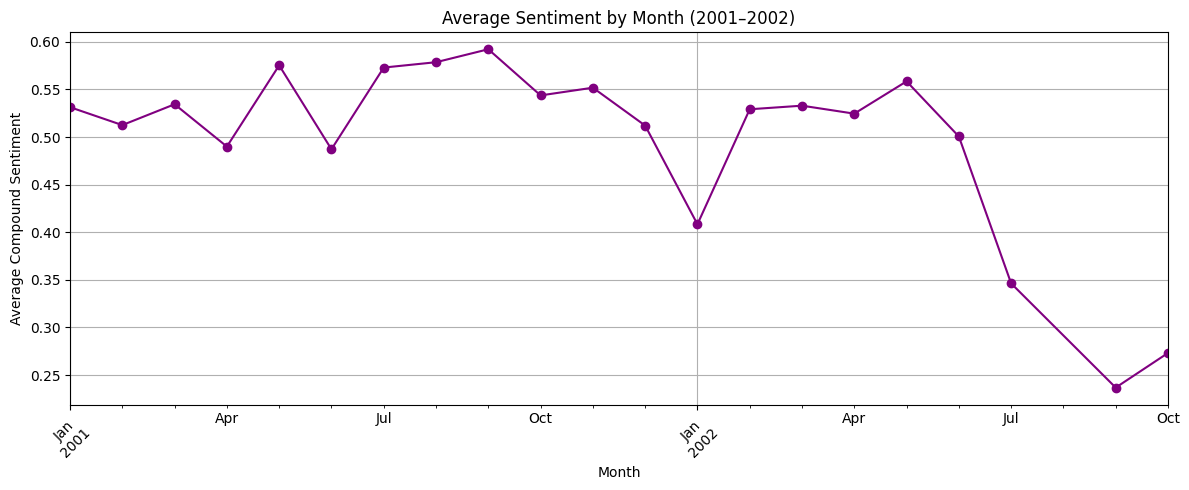

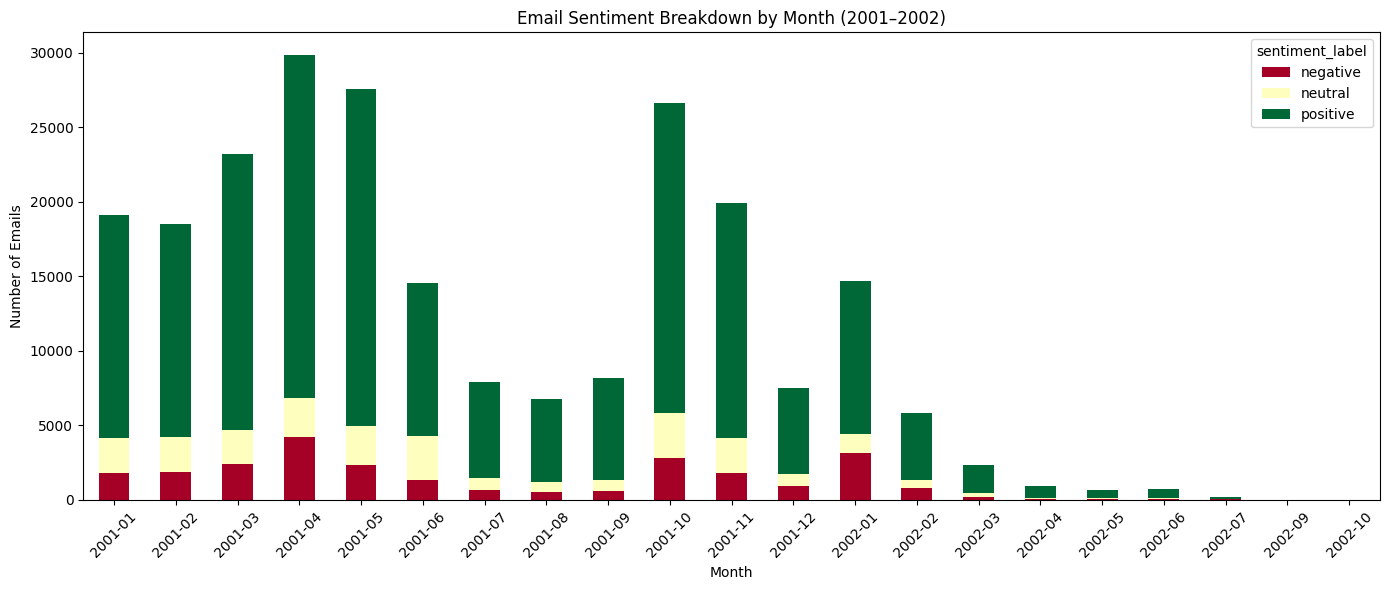

In [10]:
# Sentiment over time
df_cleaned['year_month'] = df_cleaned['year_month_dt'].dt.to_period('M')

monthly_sentiment = df_cleaned.groupby('year_month')['compound'].mean()

monthly_sentiment.plot(figsize=(12, 5), marker='o', color='purple')
plt.title("Average Sentiment by Month (2001–2002)")
plt.xlabel("Month")
plt.ylabel("Average Compound Sentiment")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly sentiment breakdown
monthly_counts = df_cleaned.groupby(['year_month', 'sentiment_label']).size().unstack().fillna(0)

monthly_counts.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='RdYlGn')
plt.title("Email Sentiment Breakdown by Month (2001–2002)")
plt.ylabel("Number of Emails")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Most negative emails
most_negative = df_cleaned.sort_values(by='compound').head(10)
print(most_negative[['Date', 'From', 'Subject', 'sentiment_label', 'compound', 'body_clean']])

top_negative_senders = df_cleaned[df_cleaned['sentiment_label'] == 'negative']['employee'].value_counts().head(10)
print(top_negative_senders)

                                         Date                  From  \
87130   Sun, 21 Oct 2001 18:49:05 -0700 (PDT)  pete.davis@enron.com   
282817   Sun, 1 Apr 2001 21:53:00 -0700 (PDT)  pete.davis@enron.com   
282816   Sun, 1 Apr 2001 20:53:00 -0700 (PDT)  pete.davis@enron.com   
284478   Wed, 4 Apr 2001 05:00:00 -0700 (PDT)  pete.davis@enron.com   
284480   Wed, 4 Apr 2001 04:01:00 -0700 (PDT)  pete.davis@enron.com   
284484   Wed, 4 Apr 2001 03:01:00 -0700 (PDT)  pete.davis@enron.com   
284492   Tue, 3 Apr 2001 22:59:00 -0700 (PDT)  pete.davis@enron.com   
284493   Tue, 3 Apr 2001 21:59:00 -0700 (PDT)  pete.davis@enron.com   
284494   Tue, 3 Apr 2001 20:59:00 -0700 (PDT)  pete.davis@enron.com   
150885  Tue, 17 Apr 2001 09:41:00 -0700 (PDT)  pete.davis@enron.com   

                                                  Subject sentiment_label  \
87130      Schedule Crawler: HourAhead Failure <CODESITE>        negative   
282817     Schedule Crawler: HourAhead Failure <CODESITE>       

Crisis-related emails found: 79408


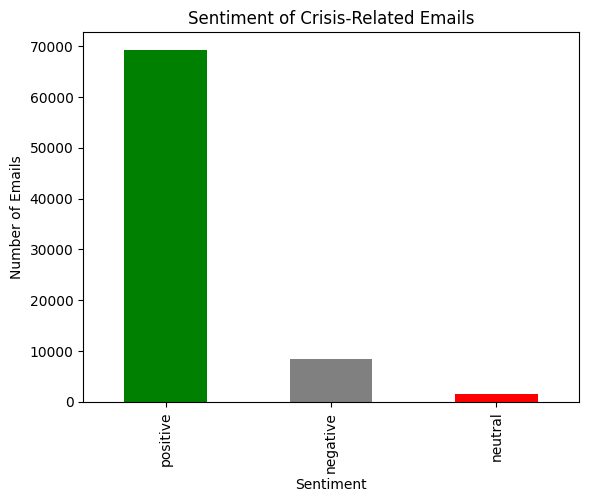

C:\Users\rmhs\AppData\Local\Temp\ipykernel_12684\2564525992.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crisis['year_month'] = df_crisis['year_month_dt'].dt.to_period('M')


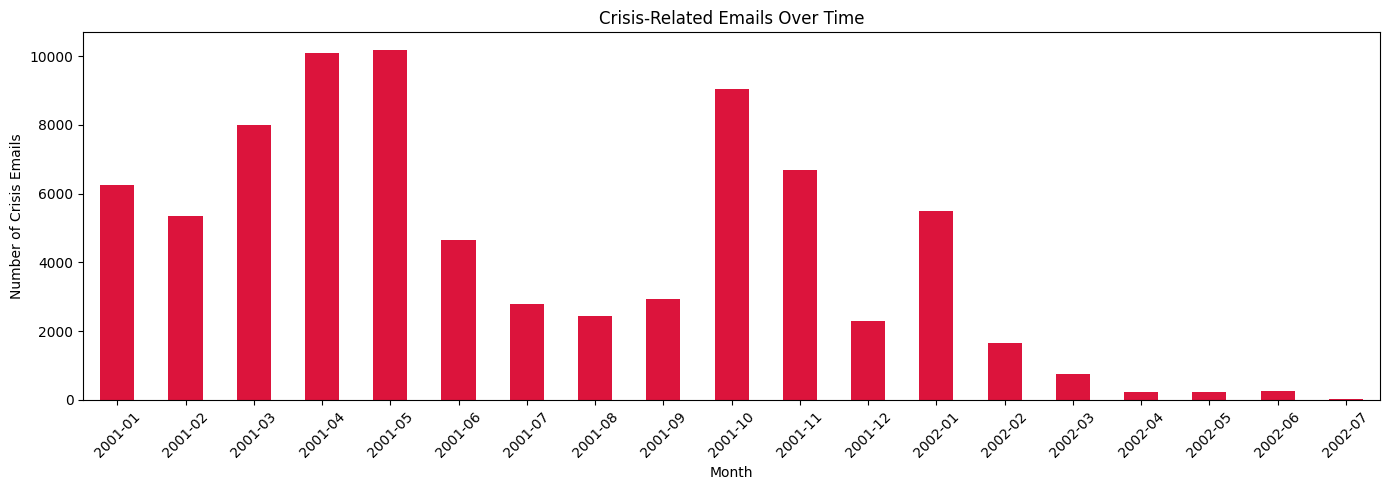

In [13]:
#Crisis keywords detection
crisis_patterns = [
    r'lay[\w]*', r'termin[\w]*', r'fir[\w]*', r'bankrupt[\w]*', r'fraud[\w]*',
    r'scandal[\w]*', r'shutdown', r'restructur[\w]*', r'resign[\w]*', r'collaps[\w]*',
    r'investigat[\w]*', r'unemploy[\w]*', r'job cut', r'downsiz[\w]*', r'clos[\w]*',
    r'leadership', r'arthur andersen', r'account[\w]*', r'lawsuit[\w]*',
    r'audit[\w]*', r'debt[\w]*']

df_cleaned['crisis_related'] = df_cleaned['body_clean'].str.contains('|'.join(crisis_patterns), case=False, na=False)
df_crisis = df_cleaned[df_cleaned['crisis_related'] == True]

print("Crisis-related emails found:", df_crisis.shape[0])

# Sentiment of crisis emails
df_crisis['sentiment_label'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Sentiment of Crisis-Related Emails")
plt.xlabel("Sentiment")
plt.ylabel("Number of Emails")
plt.show()

# Crisis messages over time
df_crisis['year_month'] = df_crisis['year_month_dt'].dt.to_period('M')
df_crisis.groupby('year_month').size().plot(
    kind='bar', figsize=(14, 5), color='crimson', title='Crisis-Related Emails Over Time')
plt.ylabel("Number of Crisis Emails")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Focus analysis on Oct 2001 – Jan 2002
df_priority = df_crisis[
    (df_crisis['year_month_dt'] >= pd.to_datetime('2001-10-01')) &
    (df_crisis['year_month_dt'] <= pd.to_datetime('2002-01-31'))
]
print("Priority period emails:", df_priority.shape[0])

Priority period emails: 23521


In [21]:
# Tokenization for top term extraction
def spacy_tokenize_crisis(text):
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    # Only keep tokens that match crisis themes
    crisis_terms_set = set([
        'layoff', 'laid', 'terminated', 'termination', 'fired', 'firing',
        'bankrupt', 'bankruptcy', 'fraud', 'scandal', 'shutdown', 'restructuring',
        'resign', 'resignation', 'collapse', 'investigation', 'unemployed',
        'debt', 'lawsuit', 'audit', 'assets', 'accounting'
    ])
    return [token.text.lower() for token in doc if token.text.lower() in crisis_terms_set]

df_priority_sample = df_priority.sample(10000, random_state=13)
df_priority_sample['tokens'] = df_priority_sample['body_clean'].progress_apply(spacy_tokenize_crisis)
df_priority_sample['year_month'] = df_priority_sample['year_month_dt'].dt.to_period('M')


100%|██████████| 10000/10000 [06:33<00:00, 25.44it/s]


In [22]:
# TERM FREQUENCY BY MONTH (TOP TERMS)
all_tokens = [token for row in df_priority_sample['tokens'] for token in row]
top_crisis_terms = [t[0] for t in Counter(all_tokens).most_common(10)]

term_trends = defaultdict(dict)
for month, group in df_priority_sample.groupby('year_month'):
    month_tokens = [token for tokens in group['tokens'] for token in tokens]
    month_counts = Counter(month_tokens)
    for term in top_crisis_terms:
        term_trends[str(month)][term] = month_counts.get(term, 0)

crisis_keywords_df = pd.DataFrame(term_trends).T.fillna(0).astype(int)

C:\Users\rmhs\AppData\Local\Temp\ipykernel_12684\664020995.py:8: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\rmhs\OneDrive - Capco\Desktop\ADS\Rajsi ADS\nlp\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


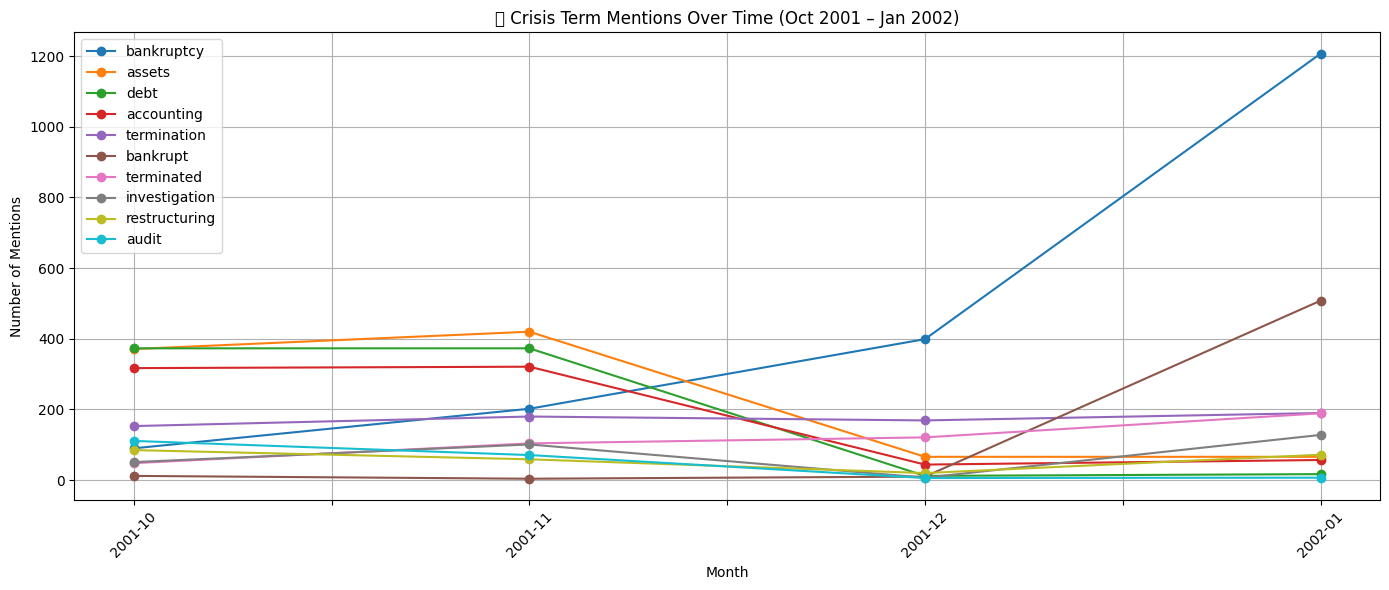

C:\Users\rmhs\AppData\Local\Temp\ipykernel_12684\664020995.py:16: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\rmhs\OneDrive - Capco\Desktop\ADS\Rajsi ADS\nlp\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


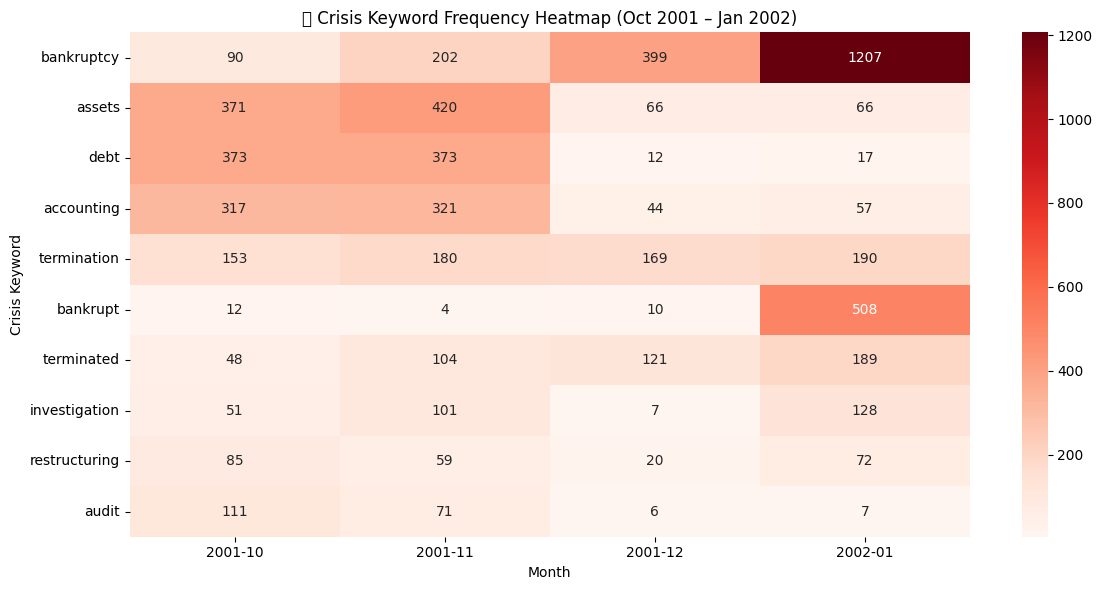

In [ ]:
# VISUALIZE TERM FREQUENCY
crisis_keywords_df.plot(figsize=(14, 6), marker='o')
plt.title(" Crisis Term Mentions Over Time (Oct 2001 – Jan 2002)")
plt.ylabel("Number of Mentions")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(crisis_keywords_df.T, cmap='Reds', annot=True, fmt='d')
plt.title(" Crisis Keyword Frequency Heatmap (Oct 2001 – Jan 2002)")
plt.xlabel("Month")
plt.ylabel("Crisis Keyword")
plt.tight_layout()
plt.show()

In [28]:
# Sort crisis-related emails by sentiment score
most_negative_crisis =df_priority_sample.sort_values(by='compound').head(3)

# Display key fields
most_negative_crisis[['Date', 'From', 'Subject', 'compound', 'body_clean']]

,Date,From,Subject,compound,body_clean
87129,"Sun, 21 Oct 2001 17:49:23 -0700 (PDT)",pete.davis@enron.com,Schedule Crawler: HourAhead Failure <CODESITE>,-0.9999,start date 102101 hourahead hour 18 hourahead ...
170029,"Thu, 22 Nov 2001 07:00:43 -0800 (PST)",tco_commercial_services@nisource.com,Columbia Reduction for Enron N A,-0.9971,company 000236 arng 3714700709 eff date 200111...
170027,"Sat, 24 Nov 2001 07:00:20 -0800 (PST)",tco_commercial_services@nisource.com,Columbia Reduction for Enron N A,-0.9971,company 000236 arng 3714700709 eff date 200111...
